# One-minute dataset overview

Aim is to see, for each moment in time in the one-minute-dataset, is there:

- A human noise?
- An animal noise?
- Both a human and an animal noise?
- No noise / unknown noise?

At the bottom of this file I display the summary, showing what percentage of times fell into which of these categories.

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import collections
import numpy as np
import seaborn as sns

In [95]:
human_noises = set(['mix traffic', 'braking', 'voices', 'electrical', 
                   'anthropogenic unknown', 'airplane', 'beep',
                   'metal', 'bus emitting', 'footsteps', 'mower', 'whistle',
                  'siren', 'coughing', 'music', 'horn', 'startthecar', 'bells', 
                    'applause', 'dog bark'])

animal_noises = set(['bird', 'wing beats', 'bat', 'fox', 
                     'grey squirrel', 'invertebrate'])

other = set(['rain', 'unknown sound'])

## Load in the annotations

In [96]:
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files/'
dataset_csv = csv.reader(open(base_path + 'urban_sounds_labels.csv'))

annotations = []  # list of all class info

def try_number(s):
    """Converts s to float if possible, else leaves as is"""
    try:
        return float(s)
    except ValueError:
        return s

# I'm basically reinventing pandas here - very silly
for count, line in enumerate(dataset_csv):
    if count == 0:
        header = line
        continue
        
    annotation = {label:try_number(item) for label, item in zip(header, line)}    
    annotation['length'] = \
        annotation['LabelEndTime_Seconds'] - annotation['LabelStartTime_Seconds']
    annotation['Label'] = annotation['Label'].strip().lower()
    annotations.append(annotation)
    
# group annotations by filename
file_annotations = collections.defaultdict(list)
for annotation in annotations:
    file_annotations[annotation['Filename']].append(annotation)

## From the annotations, work out the lengths of each lael type

I do this by forming two vectors for each sound file, one for human and one for animal sounds. These are filled with ones at each moment that a human or animal sound is present.

Note that I sort of have to do it this complex way. I can't just look at the length of time of each annotation, or I wouldn't be able to see where human and animal noises overlap. Also multiple animal noises can occur at a time, and I don't want to double count.

In [97]:
# this actually doesn't matter to be correct - it is more the resolution at which we compute statistics
sample_rate = 24000 
file_len_in_seconds = 60

# blank
just_animals = 0
just_humans = 0
animals_and_humans = 0
nothing = 0

for filename, annotations in file_annotations.iteritems():
    # first row is human, second is animal, third is other/blank
    labels = np.zeros((2, sample_rate*file_len_in_seconds))
    
    for annot in annotations:
        start_point = int(annot['LabelStartTime_Seconds'] * sample_rate)
        end_point =  int(annot['LabelEndTime_Seconds'] * sample_rate)
        
        if annot['Label'] in human_noises:
            labels[0, start_point:end_point] = 1
        elif annot['Label'] in animal_noises:
            labels[1, start_point:end_point] = 1
        elif annot['Label'] in other:
            pass
        else:
            raise Exception("Unknown label ", annot['Label'])
    
    # sum up the labels:
    animals_and_humans += float(
        np.sum(np.logical_and(labels[0, :]==1, labels[1, :]==1))) / float(sample_rate)
    just_animals += float(
        np.sum(np.logical_and(labels[0, :]==0, labels[1, :]==1))) / float(sample_rate)
    just_humans += float(
        np.sum(np.logical_and(labels[0, :]==1, labels[1, :]==0))) / float(sample_rate)
    nothing += float(
        np.sum(np.logical_and(labels[0, :]==0, labels[1, :]==0))) / float(sample_rate)
    

## Display the findings nicely(ish)

Total length of sound files is 21720.00 seconds
(Sanity check: 21720.00)

There are human noises occuring 77.32% of the time
There are animal noises occuring 11.85% of the time
7.12% of the dataset has both animal and human noises happening
17.95% of the dataset has no animal or human noise

 (THe above percentages shouldn't add up to 100)


                 SUMMARY TABLE 
           (numbers are in seconds) 

               | Animal       | No animal    |
----------------------------------------------
Human          | 1546.02      | 15247.32     |
No human       | 1028.52      | 3898.14      |
----------------------------------------------




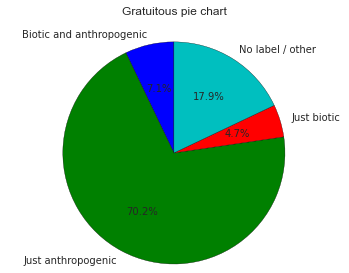

In [99]:
# Summerising the file
total_length = (just_animals + just_humans + animals_and_humans + nothing)
print "Total length of sound files is %.2f seconds" % total_length
    
print "(Sanity check: %.2f)" % (60 * len(file_annotations))

# Printing some percentages
print ""
print "There are human noises occuring %0.2f%% of the time" % \
    (100 * ((just_humans + animals_and_humans) / total_length))
    
print "There are animal noises occuring %0.2f%% of the time" % \
    (100 * ((just_animals + animals_and_humans) / total_length))
    
print "%0.2f%% of the dataset has both animal and human noises happening" % \
    (100 * ((animals_and_humans) / total_length))
    
print "%0.2f%% of the dataset has no animal or human noise" % \
    (100 * (nothing / total_length))

print "\n (THe above percentages shouldn't add up to 100)"

# Creating a table
print "\n\n                 SUMMARY TABLE \n           (numbers are in seconds) \n"
print " " * 15 + "| Animal       | No animal    |"
print "-" * 46
print "Human".ljust(15) + \
    ("| %.2f" % animals_and_humans).ljust(15) + \
    ("| %.2f" % just_humans).ljust(15) + '|'
print "No human".ljust(15) + \
    ("| %.2f" % just_animals).ljust(15) + \
    ("| %.2f" % nothing).ljust(15) + '|'
print  "-" * 46
print "\n"

# Pie chart (sorry)
plt.pie([animals_and_humans, just_humans, just_animals, nothing], 
        labels=['Biotic and anthropogenic', 'Just anthropogenic', 'Just biotic', 'No label / other'], 
        autopct='%1.1f%%', startangle=90)
plt.axis('equal');
plt.title('Gratuitous pie chart', y=1.1);